In [1]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils

In [2]:
# Products`
df_products = pd.read_excel(r"/Users/naveenraj/Desktop/Naveen/Project/data_movies.xlsx", sheet_name="products")

df_products = df_products[~df_products["genres"].isna()]
df_products["product"] = range(0,len(df_products))
df_products["name"] = df_products["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
df_products["date"] = df_products["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip()) 
                                                             if "(" in x else np.nan)

## add features
df_products["date"] = df_products["date"].fillna(9999)
df_products["old"] = df_products["date"].apply(lambda x: 1 if x < 2000 else 0)

df_products

,movieId,title,genres,product,name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9736,Black Butler: Book of the Atlantic,2017.0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9737,No Game No Life: Zero,2017.0,0
9739,193585,Flint (2017),Drama,9738,Flint,2017.0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9739,Bungo Stray Dogs: Dead Apple,2018.0,0


In [3]:
df_users = pd.read_excel(r"/Users/naveenraj/Desktop/Naveen/Project/data_movies.xlsx", sheet_name="users").head(10000)

In [4]:
df_users["user"] = df_users["userId"].apply(lambda x: x-1)

df_users["timestamp"] = df_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
df_users["daytime"] = df_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
df_users["weekend"] = df_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

df_users = df_users.merge(df_products[["movieId","product"]], how="left")
df_users = df_users.rename(columns={"rating":"y"})

In [5]:
df_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 19:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 19:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 19:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 20:03:35,0,0,1,43
4,1,50,5.0,2000-07-30 19:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
9995,66,248,3.0,2005-04-11 04:41:32,65,0,0,212
9996,66,255,0.5,2005-04-11 04:07:20,65,0,0,219
9997,66,260,2.5,2004-08-29 03:45:50,65,0,1,224
9998,66,272,3.5,2005-04-11 04:31:59,65,0,0,234


In [6]:
df_products = df_products[["product","name","old","genres"]].set_index("product")
df_products.head()

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [7]:
# Context
df_context = df_users[["user","product","daytime","weekend"]]
df_context.head()

,user,product,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,0,1
4,0,46,1,1


In [8]:
df_users = df_users[["user","product","y"]]
df_users.head()

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


In [9]:
tags = [i.split("|") for i in df_products["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

['Film-Noir', 'Western', 'Horror', 'Fantasy', 'Documentary', 'Adventure', 'Comedy', 'Sci-Fi', 'Musical', 'Children', 'Romance', 'Animation', 'IMAX', 'Action', 'Crime', 'Drama', 'Thriller', 'Mystery', 'War']


In [10]:
for col in columns:
    df_products[col] = df_products["genres"].apply(lambda x: 1 if col in x else 0)
df_products.head()

,name,old,genres,Film-Noir,Western,Horror,Fantasy,Documentary,Adventure,Comedy,...,Children,Romance,Animation,IMAX,Action,Crime,Drama,Thriller,Mystery,War
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,1,0,1,1,...,1,0,1,0,0,0,0,0,0,0
1,Jumanji,1,Adventure|Children|Fantasy,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,1,Comedy|Romance,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,Father of the Bride Part II,1,Comedy,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


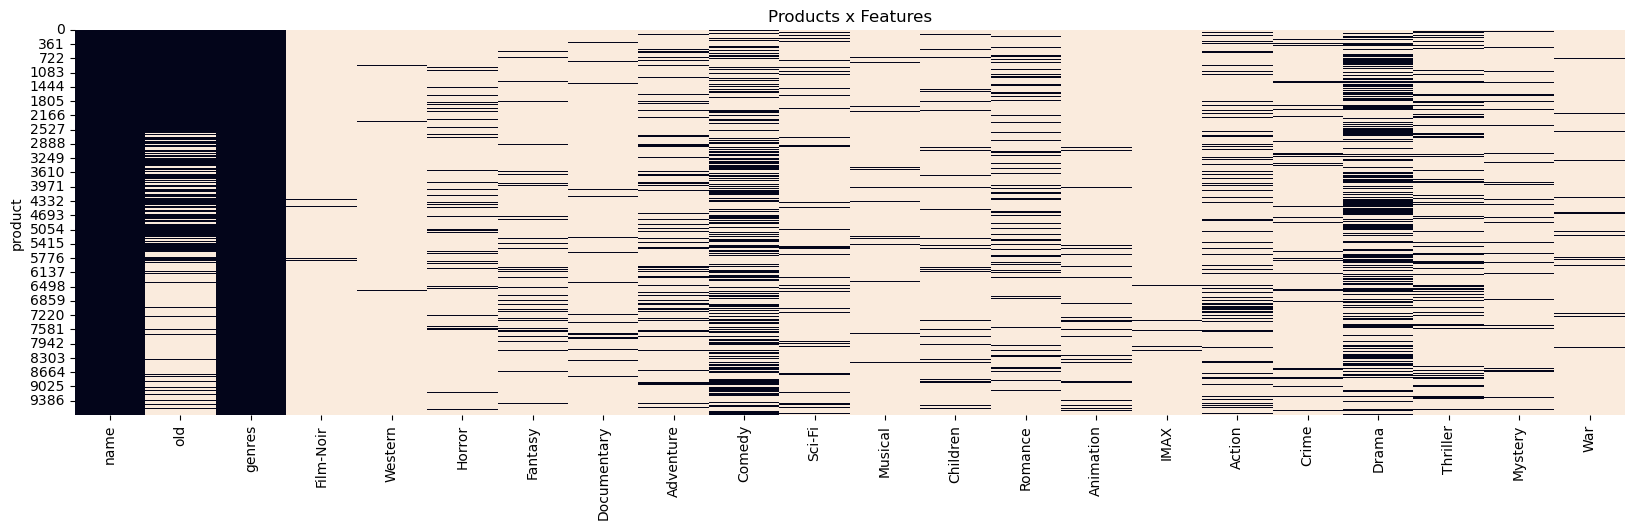

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(df_products==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

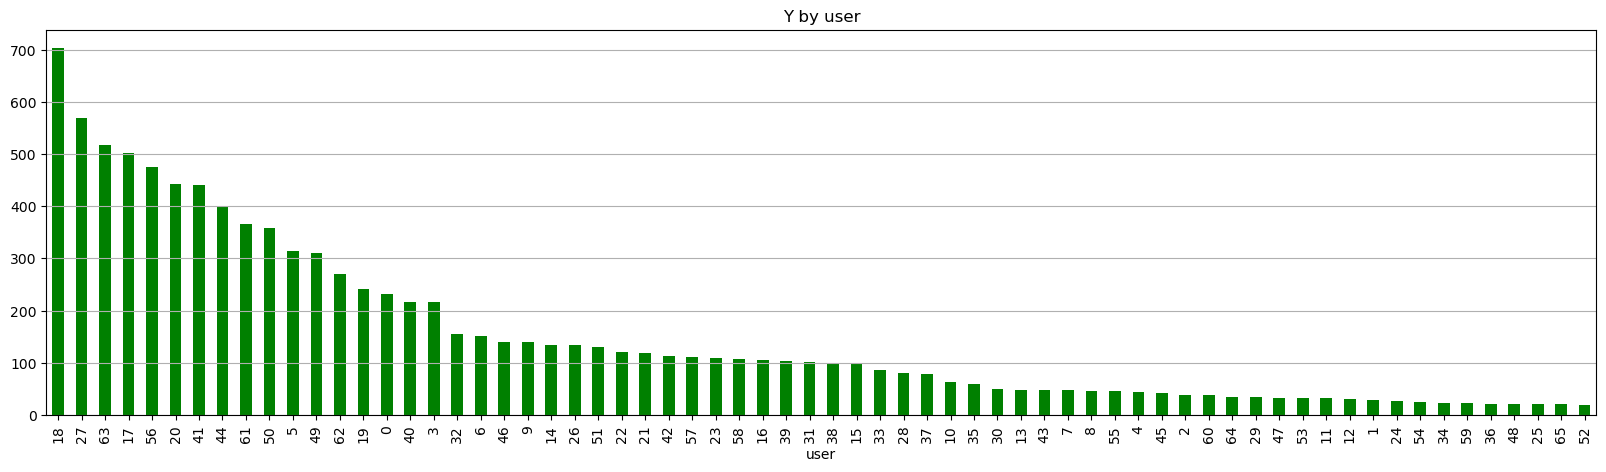

In [12]:
df_users.groupby("user").count()["product"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Y by user", figsize=(20,5)).grid(axis='y')

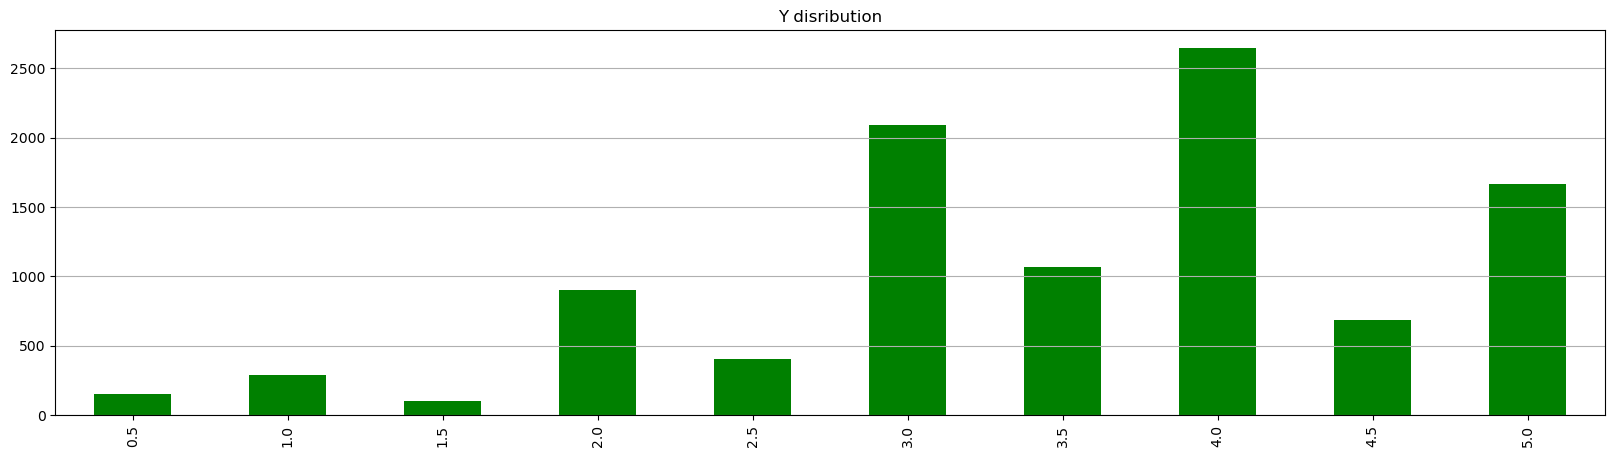

In [13]:
df_users["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y disribution", 
                                                figsize=(20,5)).grid(axis='y')
plt.show()

In [14]:
tmp = df_users.copy()
df_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(df_products.index) - set(df_users.columns))
for col in missing_cols:
    df_users[col] = np.nan
df_users = df_users[sorted(df_users.columns)]
df_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,4.0,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,4.0,NaN,3.5,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


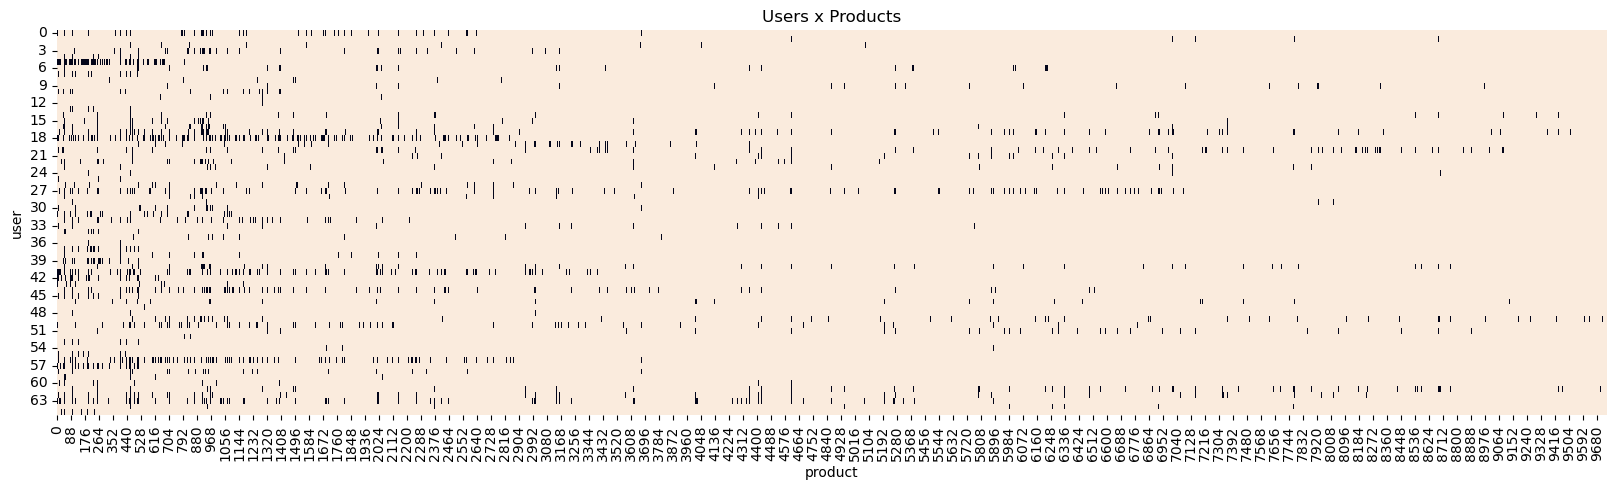

In [15]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(df_users.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Products")
plt.show()

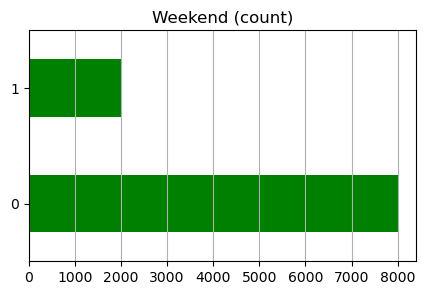

In [16]:
df_context["weekend"].value_counts().plot(kind="barh", color="green", title="Weekend (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

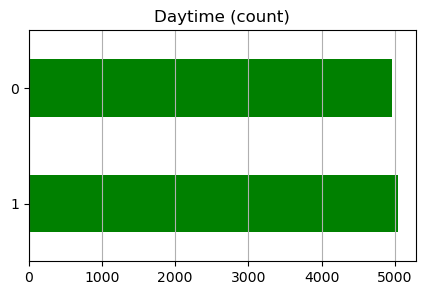

In [17]:
df_context["daytime"].value_counts().plot(kind="barh", color="green", title="Daytime (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

In [18]:
df_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(df_users.values), 
                         columns=df_users.columns, index=df_users.index)
df_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
split = int(0.8*df_users.shape[1])
split

7792

In [20]:
# Train
df_train = df_users.loc[:, :split-1]
print("non-null data:", df_train[df_train>0].count().sum())
df_train

non-null data: 9329


product,0,1,2,3,4,5,6,7,8,9,...,7782,7783,7784,7785,7786,7787,7788,7789,7790,7791
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Test
df_test = df_users.loc[:, split:]
print("non-null data:", df_test[df_test>0].count().sum())
df_test

non-null data: 671


product,7792,7793,7794,7795,7796,7797,7798,7799,7800,7801,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Select a user
i = 1
train = df_train.iloc[i].to_frame(name="y")
test = df_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 21 | test: 8


,y
product,
7792,NaN
7793,NaN
7794,NaN
7795,NaN
7796,NaN


In [23]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)
train.tail()

,y
product,
9736,NaN
9737,NaN
9738,NaN
9739,NaN
9740,NaN


In [24]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = df_products.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 9741)  x  Products (9741, 20)


In [25]:
# Numpy
import numpy as np

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat
271,8063,0.812500,0.364068
513,8305,1.000000,0.441084
584,8376,0.777778,0.077697
674,8466,0.800000,0.215465
717,8509,0.500000,0.477922
758,8550,0.875000,0.356925
889,8681,1.000000,0.327055
1036,8828,0.500000,0.033233


In [26]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [27]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
accuracy: 0.0%
mrr: 0.26


In [28]:
test.merge(
        df_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
717,8509,0.500000,0.477922,The Drop,0,Crime|Drama|Thriller
513,8305,1.000000,0.441084,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
271,8063,0.812500,0.364068,Django Unchained,0,Action|Drama|Western
758,8550,0.875000,0.356925,Ex Machina,0,Drama|Sci-Fi|Thriller
889,8681,1.000000,0.327055,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
674,8466,0.800000,0.215465,Whiplash,0,Drama
584,8376,0.777778,0.077697,Interstellar,0,Sci-Fi|IMAX
1036,8828,0.500000,0.033233,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


In [29]:
train = df_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [30]:
test = df_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


In [31]:
embeddings_size = 50
usr, prd = df_users.shape[0], df_users.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xusers_in (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 xproducts_in (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 xusers_emb (Embedding)      (None, 1, 50)                3300      ['xusers_in[0][0]']           
                                                                                                  
 xproducts_emb (Embedding)   (None, 1, 50)                487050    ['xproducts_in[0][0]']        
                                                                             

In [32]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [35]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

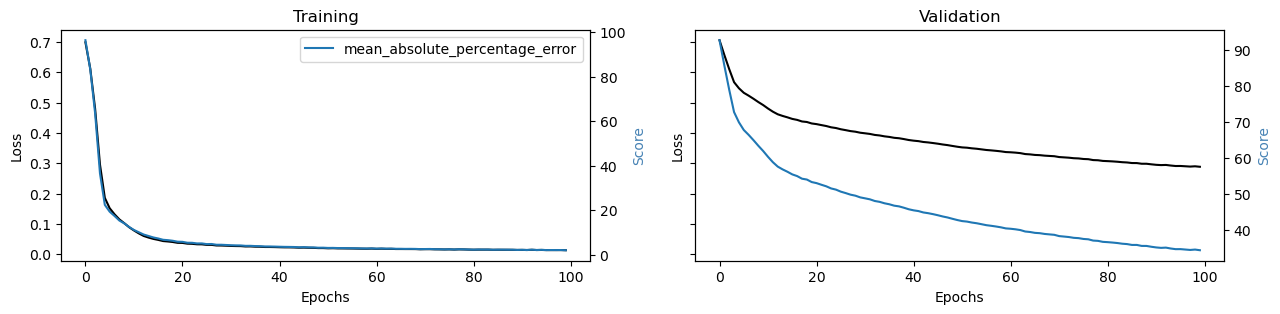

In [37]:
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [38]:
test["yhat"] = model.predict([test["user"], test["product"]])
test

21/21 [==============================] - 0s 336us/step


,user,product,y,yhat
0,1,8063,0.812500,0.550923
1,1,8305,1.000000,0.605124
2,1,8376,0.777778,0.633159
3,1,8466,0.800000,0.502561
4,1,8509,0.500000,0.386412
...,...,...,...,...
666,64,8023,0.500000,0.477678
667,64,8376,0.944444,0.422884
668,64,8438,0.666667,0.366980
669,64,8569,0.900000,0.641118


In [39]:
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.44%


In [40]:
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8681 8376 8550 8305 8828]
true positive: 3 (60.0%)
accuracy: 20.0%
mrr: 0.32


In [41]:
test[test["user"]==i].merge(
        df_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
6,1,8681,1.000000,0.714243,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
2,1,8376,0.777778,0.633159,Interstellar,0,Sci-Fi|IMAX
5,1,8550,0.875000,0.609518,Ex Machina,0,Drama|Sci-Fi|Thriller
1,1,8305,1.000000,0.605124,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
7,1,8828,0.500000,0.583389,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
0,1,8063,0.812500,0.550923,Django Unchained,0,Action|Drama|Western
3,1,8466,0.800000,0.502561,Whiplash,0,Drama
4,1,8509,0.500000,0.386412,The Drop,0,Crime|Drama|Thriller


In [42]:
train = df_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [43]:
test = df_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


In [44]:
embeddings_size = 50
usr, prd = df_users.shape[0], df_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xusers_in (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 xproducts_in (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 nn_xusers_emb (Embedding)   (None, 1, 50)                3300      ['xusers_in[0][0]']           
                                                                                                  
 nn_xproducts_emb (Embeddin  (None, 1, 50)                487050    ['xproducts_in[0][0]']        
 g)                                                                   

In [45]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


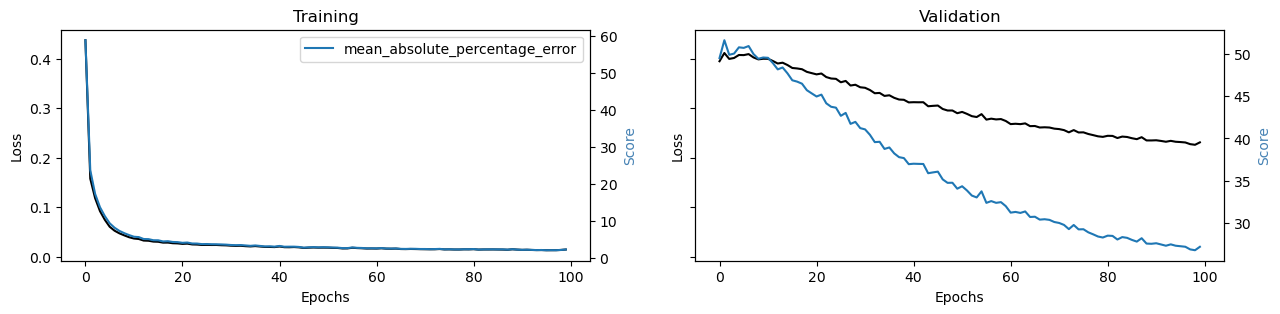

In [46]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [47]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

21/21 [==============================] - 0s 556us/step


,user,product,y,yhat
0,1,8063,0.812500,0.734429
1,1,8305,1.000000,0.635542
2,1,8376,0.777778,0.845395
3,1,8466,0.800000,0.591848
4,1,8509,0.500000,0.652002
...,...,...,...,...
666,64,8023,0.500000,0.599881
667,64,8376,0.944444,0.511472
668,64,8438,0.666667,0.486798
669,64,8569,0.900000,0.563666


In [48]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.31%


In [49]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8376 8063 8828 8509 8305]
true positive: 2 (40.0%)
accuracy: 0.0%
mrr: 0.14


In [50]:
test[test["user"]==i].merge(
        df_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
2,1,8376,0.777778,0.845395,Interstellar,0,Sci-Fi|IMAX
0,1,8063,0.812500,0.734429,Django Unchained,0,Action|Drama|Western
7,1,8828,0.500000,0.732388,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
4,1,8509,0.500000,0.652002,The Drop,0,Crime|Drama|Thriller
1,1,8305,1.000000,0.635542,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
6,1,8681,1.000000,0.625550,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
5,1,8550,0.875000,0.611116,Ex Machina,0,Drama|Sci-Fi|Thriller
3,1,8466,0.800000,0.591848,Whiplash,0,Drama


In [51]:
features = df_products.drop(["genres","name"], axis=1).columns
print(features)

Index(['old', 'Film-Noir', 'Western', 'Horror', 'Fantasy', 'Documentary',
       'Adventure', 'Comedy', 'Sci-Fi', 'Musical', 'Children', 'Romance',
       'Animation', 'IMAX', 'Action', 'Crime', 'Drama', 'Thriller', 'Mystery',
       'War'],
      dtype='object')


In [52]:
context = df_context.drop(["user","product"], axis=1).columns
print(context)

Index(['daytime', 'weekend'], dtype='object')


In [53]:
train = df_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(df_products[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(df_context, how="left")

In [54]:
train

,user,product,y,old,Film-Noir,Western,Horror,Fantasy,Documentary,Adventure,...,Animation,IMAX,Action,Crime,Drama,Thriller,Mystery,War,daytime,weekend
0,0,0,0.800000,1,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,1
1,0,2,0.750000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,5,0.750000,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,1
3,0,43,1.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,0,46,1.000000,1,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9324,65,212,0.666667,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9325,65,219,0.500000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9326,65,224,0.500000,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
9327,65,234,0.625000,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [55]:
test = df_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(df_products.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test[context] = 0

In [56]:
test.head()

,user,product,y,old,Film-Noir,Western,Horror,Fantasy,Documentary,Adventure,...,Animation,IMAX,Action,Crime,Drama,Thriller,Mystery,War,daytime,weekend
0,1,8063,0.812500,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1,8305,1.000000,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,1,8376,0.777778,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,8466,0.800000,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,8509,0.500000,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0


In [57]:
embeddings_size = 50
usr, prd = df_users.shape[0], df_users.shape[1]
feat = len(features)
ctx = len(context)

Collaborative Filtering

In [58]:
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

In [59]:
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)

In [60]:
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)

In [61]:
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

In [62]:
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)

In [63]:
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)

In [64]:
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

Content Based

In [65]:
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

In [66]:
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

In [67]:
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

In [68]:
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xusers_in (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 xproducts_in (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 nn_xusers_emb (Embedding)   (None, 1, 50)                3300      ['xusers_in[0][0]']           
                                                                                                  
 nn_xproducts_emb (Embeddin  (None, 1, 50)                487050    ['xproducts_in[0][0]']        
 g)                                                                                    

In [69]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [70]:
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

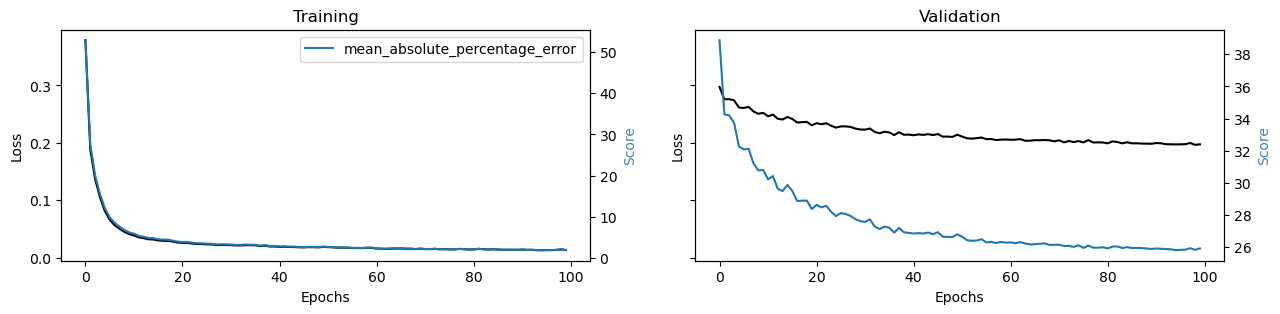

In [71]:
model = training.model
utils_plot_keras_training(training)

In [72]:
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

21/21 [==============================] - 0s 527us/step


,user,product,y,old,Film-Noir,Western,Horror,Fantasy,Documentary,Adventure,...,IMAX,Action,Crime,Drama,Thriller,Mystery,War,daytime,weekend,yhat
0,1,8063,0.812500,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0.640476
1,1,8305,1.000000,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0.493871
2,1,8376,0.777778,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.615934
3,1,8466,0.800000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.543087
4,1,8509,0.500000,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0.691886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,64,8023,0.500000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.594891
667,64,8376,0.944444,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.516367
668,64,8438,0.666667,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0.572109
669,64,8569,0.900000,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0.617800


In [73]:
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.31%


In [74]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8681 8509 8063 8376 8466]
true positive: 3 (60.0%)
accuracy: 20.0%
mrr: 0.31
